In [1]:
import astropy
import dogpile.cache
import fuzzywuzzy
import os
import re
import marvin
import marvin.utils.plot.map as mapplot
import matplotlib
import numpy as np
import numpyencoder
import packaging
import pandas
import photutils
import raven
import scipy
import sdss_access
import sdsstools
import webargs
import werkzeug
import yamlordereddictloader
import time
import matplotlib.pyplot as plt


from marvin import config
from marvin.tools import Maps
from marvin.tools.image import Image
from marvin.tools.cube import Cube
from marvin.tools.query import Query
from marvin.utils.datamodel.query.base import query_params
from marvin.tools import RSS
from marvin.utils.general.general import get_drpall_table
from marvin.api.api import Interaction

from astropy.io import fits
from astropy import units as u
from astropy import constants as C

%matplotlib inline
plt.style.use('seaborn-darkgrid')  # set matplotlib style sheet

config.mode = 'remote'
config.access = 'public'
config.use_sentry = True
config.setRelease('DR17')
config.setDR('DR17')
#config.sasurl
#config.urlmap
config.switchSasUrl(sasmode='mirror', ngrokid=None, port=5000, test=False, base=None, public=True)

[WARNING]: cannot initiate Sentry error reporting: unknown error. (UserWarning)
[INFO]: No release version set. Setting default to DR17


In [3]:
#troubleshooting code

'''
print(os.environ['SAS_BASE_DIR'])
print(marvin.config.urlmap)
testcube = Cube(plateifu='8485-1901')
print(testcube)
print(f"RA: {testcube.ra}")
print(f"Dec: {testcube.dec}")

print(testcube.nsa)

# access the spaxel from the lower left corner of the Cube for 8485-1901
spaxel = testcube.getSpaxel(0,0)
# represent the spaxel
print(spaxel)

flux = spaxel.flux
flux.plot()
print(flux.value, flux.ivar, flux.wavelength)

maps = testcube.getMaps()
print(maps)
ha = maps.getMap('emline_gflux_ha_6564')

#maps.datamodel

print(f"Database access: {config.db}")
'''

'\nprint(os.environ[\'SAS_BASE_DIR\'])\nprint(marvin.config.urlmap)\ntestcube = Cube(plateifu=\'8485-1901\')\nprint(testcube)\nprint(f"RA: {testcube.ra}")\nprint(f"Dec: {testcube.dec}")\n\nprint(testcube.nsa)\n\n# access the spaxel from the lower left corner of the Cube for 8485-1901\nspaxel = testcube.getSpaxel(0,0)\n# represent the spaxel\nprint(spaxel)\n\nflux = spaxel.flux\nflux.plot()\nprint(flux.value, flux.ivar, flux.wavelength)\n\nmaps = testcube.getMaps()\nprint(maps)\nha = maps.getMap(\'emline_gflux_ha_6564\')\n\n#maps.datamodel\n\nprint(f"Database access: {config.db}")\n'

In [4]:
# get and format an API url to retrieve basic Cube properties
plateifu = '7443-12701'
url = config.urlmap['api']['getCube']['url']

# create and send the request, and retrieve a response
response = Interaction(url.format(name=plateifu))

# check your response's status code
print(response.status_code, "good if 200")
200

# get the data in your response
data = response.getData()
#print(data)

200 good if 200


In [5]:
images = Image.from_list(['10839-12701', '8330-3701', '9028-12704', '9033-9102'])
for image in images:
    image.show()

[WARNING]: subprocess 164 is still running (ResourceWarning)
[WARNING]: subprocess 17868 is still running (ResourceWarning)
[WARNING]: subprocess 14096 is still running (ResourceWarning)
[WARNING]: subprocess 1904 is still running (ResourceWarning)


In [6]:
#images2 = marvin.utils.general.images.get_images_by_plate(8485)
#for image in images2:
#    image.show()

**Goal:** redo VCARRS with expanded search using the small angle approx
* use sklearn to train a model on sorting spiral vs elliptical
* repeat rotation curve and CLD measurements to calculate DM content
* create histograms of DM fraction vs # of galaxies, see if there's any differences between spiral and elliptical
* **hypothesis:** elliptical galaxies have higher DM content due to slower rotation and random stellar orbits

8481-6103 0.04674866


[WARNING]: cannot load NSA information for mangaid='51-77'. (MarvinUserWarning)


No cube for 12040-6102
9028-3702 0.04822156


[WARNING]: cannot load NSA information for mangaid='51-70'. (MarvinUserWarning)


No cube for 10148-1901
8249-3703 0.026438024
8137-12705 0.0409416
8991-1901 0.05013228
8322-6104 0.046931956
8091-9101 0.031411078
8247-9101 0.041565735


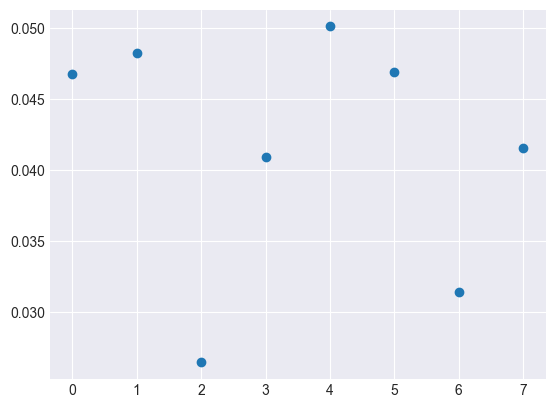

In [8]:
# testing different ways to get NSA parameters, specifically redshift z

images3 = marvin.utils.general.images.get_random_images(10)
test = []

for item in images3:
    #print(item.__dict__)
    ifu = item.plateifu

    try:
        cube = Cube(plateifu = ifu)
        print(ifu, cube.nsa['z'])
        test.append(cube.nsa['z'])

    except:
        print(f"No cube for {ifu}")

xaxis = np.arange(0, len(test), 1)
plt.scatter(xaxis, test)

In [4]:
# the above method is slow and inefficient and sometimes fails completely when it finds a galaxy that lacks NSA params
# Query is much faster:

from marvin.tools.query import Query

my_filter = 'nsa.z < 0.05'
q = Query(search_filter=my_filter)
print(q)

# run the query
r = q.run()

# print some results information
print(r)
print('number of results:', r.totalcount)

Marvin Query(filter='nsa.z < 0.05', mode='remote', data_origin='api')
Marvin Results(query=nsa.z < 0.05, totalcount=7151, count=100, mode=remote)
number of results: 7151


Easy First Step: Rotation Curve
Steps:
1. Import units and constants
2. Seach for galaxies, start with a filter where the inclination angle ~ 0 degrees to our viewing plane
3. Get a stellar velocity dispersion map for every such galaxy
4. Calculate mass from the velocities

* using previous work (STARS final project) as hints

elpetro_ba is the b/a ratio. a high b/a (close to 1) means that the galaxy is close to perfectly face-on, while a low b/a (close to 0) means that the galaxy is perfectly edge-on

In [5]:
my_filter = 'nsa.elpetro_ba > 0.25 and nsa.elpetro_ba < 0.5'
q = Query(search_filter=my_filter)
print(q)

# run the query
r = q.run()

# print some results information
print('number of results:', r.totalcount)

Marvin Query(filter='nsa.elpetro_ba > 0.25 and nsa.elpetro_ba < 0.5', mode='remote', data_origin='api')
number of results: 1597


In [67]:
myfilter = 'nsa.sersic_logmass > 10 and nsa.sersic_logmass < 12 and nsa.elpetro_ba > 0.2 and nsa.elpetro_ba < 0.5'
q = Query(search_filter = myfilter) 
results = q.run()
    
# Get the total count of results
total_count = results.totalcount
print(total_count)

601


In [68]:
#query_params.list_params()
query = Query(search_filter = myfilter, limit = total_count)
results = query.run()

mangaids = []
sersic_logmass = []

for i in range(total_count):
    #print(i, results.results[i])
    mangaids.append(results.results[i][0])
    sersic_logmass.append(results.results[i][2])

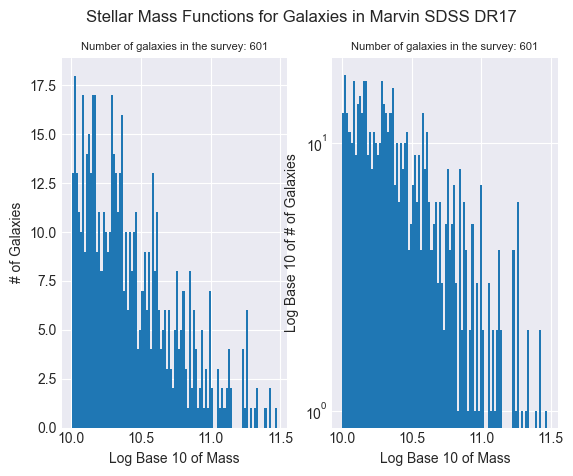

In [69]:
#test = np.arange(1, len(sersic_logmass)+1, 1)

nbins = 100

avg_logmass = (np.sum(sersic_logmass) / len(sersic_logmass))

fig, ax = plt.subplots(1, 2)
ax[0].hist(sersic_logmass, bins = nbins)
ax[1].hist(sersic_logmass, bins = nbins)
ax[0].set_xlabel("Log Base 10 of Mass")
ax[0].set_ylabel("# of Galaxies")
ax[1].set_xlabel("Log Base 10 of Mass")
ax[1].set_ylabel("Log Base 10 of # of Galaxies")
ax[1].set_yscale("log")
#plt.axvline(x=avg_logmass, color='tab:red', linestyle='--', label= f'Average Sersic Log Mass = {avg_logmass:.2f}')
plt.suptitle("Stellar Mass Functions for Galaxies in Marvin SDSS DR17")
ax[0].set_title(f"Number of galaxies in the survey: {len(sersic_logmass)}", fontsize = 8)
ax[1].set_title(f"Number of galaxies in the survey: {len(sersic_logmass)}", fontsize = 8)
#ax.legend()
plt.show()

In [10]:
#testifus = ['8485-1901', '8987-12702']
stellarvel = []
stellarsigmacorr = []
test3 = []

for index, mid in enumerate(mangaids[0:10]):
    print(index, mid)
    tries = 0
    while tries < 3:
        
        try:
            maps = Maps(mangaid = mid)
            stellar_velocity = maps.getMap('stellar_vel')            # Stellar velocity is stored in the 'stellar_vel' property.
            stellarvel.append(stellar_velocity)
            stellar_sigma_raw = maps.getMap('stellar_sigma')         # The raw stellar velocity dispersion is in 'stellar_sigma'; must be corrected for instrumental resolution.
            stellar_sigma_corrected = stellar_sigma_raw.inst_sigma_correction()  # Apply the instrumental correction to the velocity dispersion. This will ignore points where the correction is larger than the raw value.
            stellarsigmacorr.append(stellar_sigma_corrected)
            radius = maps.getMap('spx_ellcoo_r_re')
            test3.append(radius)
            break

        except marvin.core.exceptions.MarvinError:
            print("marvin.core.exceptions.MarvinError")
            time.sleep(15)
            tries += 1

        if tries == 3:
            print("Uh oh!")

0 1-10177


[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: invalid value encountered in divide (RuntimeWarning)


1 1-10425
2 1-106664
3 1-107841
4 1-108250


[WARNING]: invalid value encountered in sqrt (RuntimeWarning)


5 1-109244
6 1-109394
7 1-109909
8 1-113418
9 1-114325


In [117]:
fname = 'C:/Users/steph/sas/dr17/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits'
dapall = fits.getdata(fname)

DMratios = []

for index, mid in enumerate(mangaids[0:100]):
    row = dapall[dapall['MANGAID'] == mid]
    ba = row['NSA_ELPETRO_BA'][0]
    phi = row['NSA_ELPETRO_PHI'][0]
    theta=-(90-phi)
    a = 15 #define
    b = ba*a

    maps = Maps(mangaid = mid, mode = 'remote')
    cube = Cube(id)
    testvmap = maps['stellar_sigma']
    testrmap = (maps['spx_ellcoo_r_re'].value * dapall[dapall['MANGAID'] == mid]['nsa_elpetro_th50_r'])

    c = testvmap.shape[0]//2
    aperture = cube.getAperture((c,c),(a,b,np.radians(theta)),aperture_type='elliptical')
    spax = aperture.getSpaxels()

    mmap = np.zeros(testvmap.shape)
    for spaxel in spax:
        x = spaxel.x
        y = spaxel.y
        v = testvmap[y,x]
        r = testrmap[y,x]
    
        m = ((v.value**2)*((r*u.kpc).to(u.km).value)/(C.G.to(u.km**3 / u.M_sun / u.s**2).value))
        #print(v, r, m)
        mmap[y,x] = m

    rot_Mass = mmap.max()
    lum_Mass = 10 ** Maps(id).nsa['sersic_logmass']
    Mratio = rot_Mass / lum_Mass
    print(index, mid, rot_Mass, lum_Mass, Mratio)
    DMratios.append(Mratio)

print(DMratios)


#plt.imshow(mmap,origin='lower', cmap = 'viridis')
#plt.colorbar(label='Mass (in Solar Masses)', orientation = 'vertical')
#plt.title('Cumulative Mass Map')
#plt.xlabel('Spaxels')
#plt.ylabel('Spaxels')

0 1-10177 37938930210.39874 12752851000.000002 2.9749371501634214
1 1-10425 275790346015.7043 12752851000.000002 21.625779679830355
2 1-106664 44681701617.15386 12752851000.000002 3.503663738967377
3 1-107841 27795584123.830147 12752851000.000002 2.179558447270351
4 1-108250 17121971891.053335 12752851000.000002 1.3425995403736257
5 1-109244 27970284164.938915 12752851000.000002 2.1932573480972146
6 1-109394 21651362851.638573 12752851000.000002 1.6977664721118886
7 1-109909 96235364987.38724 12752851000.000002 7.546184377704031
8 1-113418 22461072242.04423 12752851000.000002 1.7612588935638178
9 1-114325 12429087453.372456 12752851000.000002 0.9746124575102817
10 1-114973 263574844099.81967 12752851000.000002 20.667915284183877
11 1-115128 18220414103.44719 12752851000.000002 1.4287326107273728
12 1-115162 22555679814.16861 12752851000.000002 1.7686774364546882
13 1-115317 17321754055.308956 12752851000.000002 1.3582652267566644
14 1-115345 27178528980.92726 12752851000.000002 2.13117

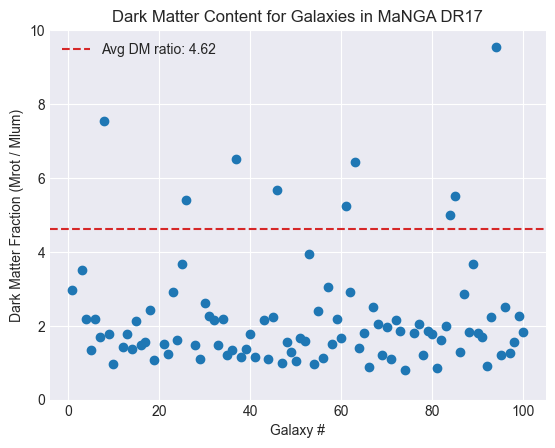

In [121]:
nbins = 100
test = np.arange(1, len(DMratios)+1, 1)
avg_DM_ratio = np.sum(DMratios) / len(DMratios)

fig, ax = plt.subplots()

ax.scatter(test, DMratios, color = "tab:blue")
ax.set_xlabel("Galaxy #")
ax.set_ylabel("Dark Matter Fraction (Mrot / Mlum)")
ax.set_ylim(0, 10)
plt.axhline(y = avg_DM_ratio, label = f"Avg DM ratio: {avg_DM_ratio:.2f}", linestyle = "--", color = "tab:red")
ax.set_title("Dark Matter Content for Galaxies in MaNGA DR17")
ax.legend()
plt.show()